In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pmdarima as pm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
from sklearn.metrics import mean_squared_error

In [2]:
start = '2014-05-29'
end = '2024-05-30'
stock = 'GOOG'

data = yf.download(stock, start, end)

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.reset_index(inplace=True)

In [4]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-05-29,28.090378,28.122789,27.859013,27.927326,27.927326,27082150
1,2014-05-30,27.963226,27.990652,27.719397,27.917852,27.917852,35422988
2,2014-06-02,27.958241,27.968212,27.211790,27.620667,27.620667,28700582
3,2014-06-03,27.474070,27.541386,27.053225,27.172398,27.172398,37332215
4,2014-06-04,27.000870,27.355396,26.863747,27.158438,27.158438,36329469
...,...,...,...,...,...,...,...
2513,2024-05-22,178.399994,178.852005,176.779999,178.000000,178.000000,16189400
2514,2024-05-23,178.779999,179.910004,174.539993,175.059998,175.059998,14928400
2515,2024-05-24,176.520004,177.304001,175.199997,176.330002,176.330002,11400600
2516,2024-05-28,175.740005,178.509995,175.679993,178.020004,178.020004,15655300


# Handle null values

In [5]:
data.dropna(inplace=True)

In [6]:
data_train = pd.DataFrame(data.Close[0: int(len(data)*0.80)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])

In [7]:
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:]

In [8]:
lag = 15

In [9]:
model = pm.auto_arima(train['Close'], seasonal=True, m=lag)
forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)
forecast_df = pd.DataFrame(forecast, index=test.index, columns=['Forecast'])
test['forecast'] = forecast.values

C:\Users\Admin\AppData\Local\Temp\ipykernel_24328\1139029889.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['forecast'] = forecast.values


In [10]:
test.head()

,Date,Open,High,Low,Close,Adj Close,Volume,forecast
2014,2022-05-26,106.050499,108.955254,105.487999,108.295998,108.295998,30288000,105.662737
2015,2022-05-27,109.788498,112.867996,109.550003,112.799004,112.799004,29924000,105.809140
2016,2022-05-31,113.079002,116.433502,112.572502,114.039001,114.039001,51302000,105.793847
2017,2022-06-01,114.931503,117.399002,113.550499,114.137001,114.137001,28630000,105.859458
2018,2022-06-02,114.188004,117.898003,113.307999,117.746002,117.746002,27472000,105.884589


In [11]:
train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-05-29,28.090378,28.122789,27.859013,27.927326,27.927326,27082150
1,2014-05-30,27.963226,27.990652,27.719397,27.917852,27.917852,35422988
2,2014-06-02,27.958241,27.968212,27.211790,27.620667,27.620667,28700582
3,2014-06-03,27.474070,27.541386,27.053225,27.172398,27.172398,37332215
4,2014-06-04,27.000870,27.355396,26.863747,27.158438,27.158438,36329469


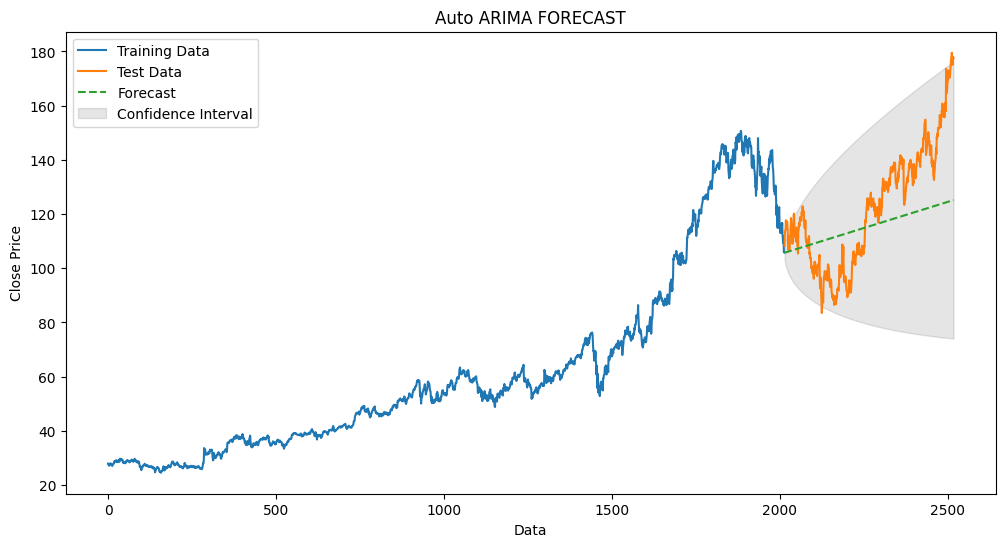

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label = 'Training Data')
plt.plot(test['Close'], label = 'Test Data')
plt.plot(test['forecast'], label = 'Forecast', linestyle = 'dashed')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color = 'k', alpha = 0.1, label = 'Confidence Interval')
plt.title('Auto ARIMA FORECAST')
plt.xlabel('Data')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [13]:
residual_arima = model.resid()

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
residual_arima_normalized = scaler.fit_transform(residual_arima.values.reshape(-1, 1))

In [15]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,
               input_shape = (residual_arima_normalized.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation='relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units =1))

c:\Users\Admin\OneDrive\Desktop\stock_market_analysis\sachinenv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
X_train = np.reshape(residual_arima_normalized, (len(residual_arima_normalized), 1, 1))
y_train = np.reshape(residual_arima_normalized, (len(residual_arima_normalized), 1, ))

In [57]:
model.fit(X_train, y_train, epochs=300, batch_size=64)

Epoch 1/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7119e-04
Epoch 2/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0996e-04
Epoch 3/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1736e-04
Epoch 4/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6029e-04
Epoch 5/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9905e-04
Epoch 6/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9787e-04
Epoch 7/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2542e-04
Epoch 8/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9068e-04
Epoch 9/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6859e-04
Epoch 10/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2427e-04
Epoch 11/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6546e-04
Epoch 12/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9436e-04
Epoch 13/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7875e-04
Epoch 14/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1301e-04
Epoch 15/300
32

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 60)          │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 80)          │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 80)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,285 (2.05 MB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 357,524 (1.36 MB)

In [20]:
X_test = np.reshape(residual_arima_normalized[-len(test):], (len(test), 1, 1))
residuals_lstm_normalized = model.predict(X_test)
residuals_lstm = scaler.inverse_transform(residuals_lstm_normalized)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


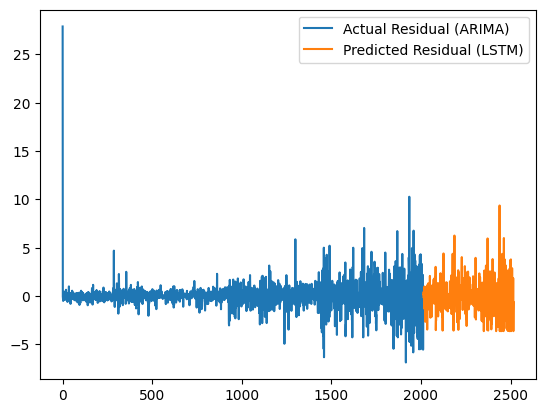

In [21]:
plt.plot(residual_arima.index, residual_arima.values, label = "Actual Residual (ARIMA)")
plt.plot(test.index, residuals_lstm, label = "Predicted Residual (LSTM)")
plt.legend()
plt.show()

In [22]:
y_pred = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [23]:
y_pred

array([[0.19459142],
       [0.2102998 ],
       [0.20001751],
       [0.20421156],
       [0.19344468],
       [0.15972467],
       [0.22597775],
       [0.20876613],
       [0.2065036 ],
       [0.20847483],
       [0.12106314],
       [0.20093137],
       [0.20693952],
       [0.2229696 ],
       [0.20818278],
       [0.17442207],
       [0.19072182],
       [0.22054026],
       [0.21269956],
       [0.15392107],
       [0.20371297],
       [0.09800367],
       [0.23052475],
       [0.22540343],
       [0.22454582],
       [0.23132119],
       [0.23525602],
       [0.18542837],
       [0.2067549 ],
       [0.21579069],
       [0.23425728],
       [0.15770571],
       [0.20281366],
       [0.19130628],
       [0.19895571],
       [0.19406682],
       [0.2576561 ],
       [0.1924943 ],
       [0.20499216],
       [0.13320173],
       [0.18576221],
       [0.2202453 ],
       [0.15658367],
       [0.21918954],
       [0.21033674],
       [0.13531677],
       [0.17989525],
       [0.185

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
residual_arima_normalized = scaler.fit_transform(residual_arima.values.reshape(-1, 1))

In [25]:
from keras.layers import GRU

In [26]:
model_gru = Sequential()
model_gru.add(GRU(units=50, activation='relu', return_sequences=True,
                  input_shape=(residual_arima_normalized.shape[1], 1)))
model_gru.add(Dropout(0.2))

model_gru.add(GRU(units=60, activation='relu', return_sequences=True))
model_gru.add(Dropout(0.3))

model_gru.add(GRU(units=80, activation='relu', return_sequences=True))
model_gru.add(Dropout(0.4))

model_gru.add(GRU(units=60, activation='relu'))
model_gru.add(Dropout(0.))

model_gru.add(Dense(units=1))

c:\Users\Admin\OneDrive\Desktop\stock_market_analysis\sachinenv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
model_gru.compile(optimizer='adam', loss= 'mean_squared_error')

In [28]:
X_train = np.reshape(residual_arima_normalized, (len(residual_arima_normalized), 1, 1))
y_train = np.reshape(residual_arima_normalized, (len(residual_arima_normalized), 1, ))

In [29]:
model_gru.fit(X_train, y_train, epochs=300, batch_size=64)

Epoch 1/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0255
Epoch 2/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 3/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025
Epoch 4/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 5/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015  
Epoch 6/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012
Epoch 7/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 8/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1685e-04
Epoch 9/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8593e-04
Epoch 10/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7789e-04
Epoch 11/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1038e-04
Epoch 12/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9018e-04
Epoch 13/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5105e-04
Epoch 14/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4413e-04
Epoch 15/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0

In [30]:
model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 50)          │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 1, 60)          │        20,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 1, 80)          │        34,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 80)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 60)             │        25,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,435 (1.00 MB)

 Trainable params: 87,811 (343.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 175,624 (686.04 KB)

In [31]:
X_test = np.reshape(residual_arima_normalized[-len(test):], (len(test), 1, 1))
residuals_gru_normalized = model_gru.predict(X_test)
residuals_gru = scaler.inverse_transform(residuals_gru_normalized)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


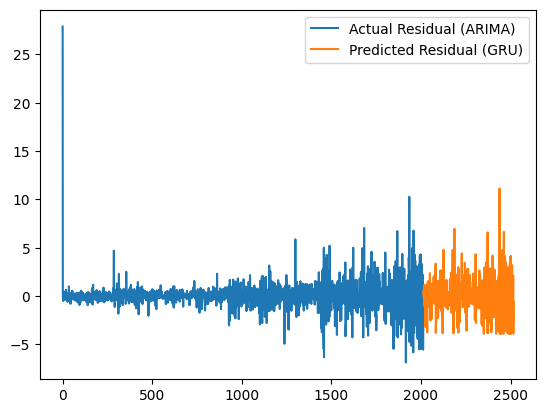

In [32]:
plt.plot(residual_arima.index, residual_arima.values, label = "Actual Residual (ARIMA)")
plt.plot(test.index, residuals_gru, label = "Predicted Residual (GRU)")
plt.legend()
plt.show()

In [33]:
test['Forecast Hybrid'] = test['forecast'].values+np.hstack(residuals_gru)
test['Forecast Hybrid Gru'] = test['forecast'].values+np.hstack(residuals_gru_normalized)

C:\Users\Admin\AppData\Local\Temp\ipykernel_24328\1484576204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Forecast Hybrid'] = test['forecast'].values+np.hstack(residuals_gru)
C:\Users\Admin\AppData\Local\Temp\ipykernel_24328\1484576204.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Forecast Hybrid Gru'] = test['forecast'].values+np.hstack(residuals_gru_normalized)


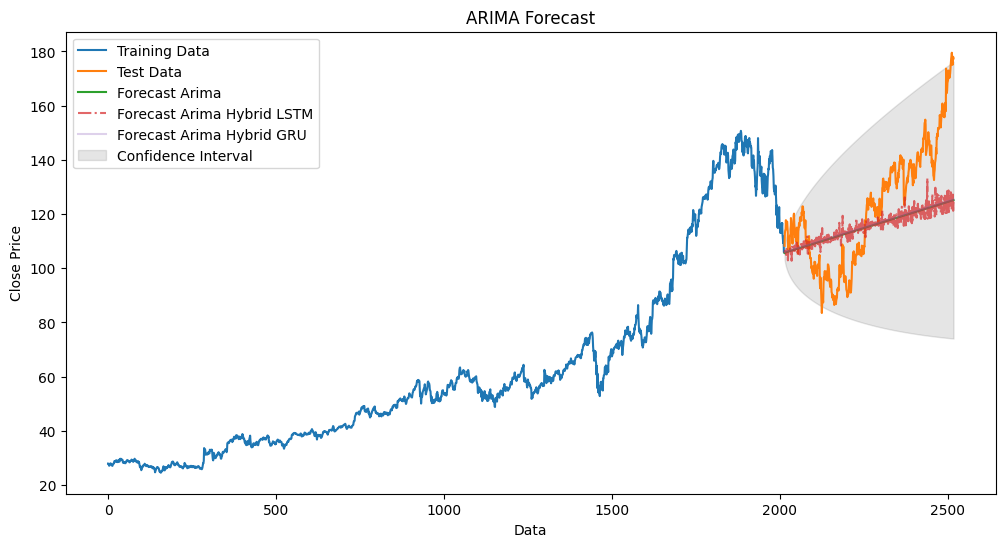

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label = 'Training Data')
plt.plot(test['Close'], label = 'Test Data')
plt.plot(test['forecast'], label = 'Forecast Arima', linestyle = 'solid')
plt.plot(test['Forecast Hybrid'], label = 'Forecast Arima Hybrid LSTM', linestyle = 'dashdot', alpha = 0.7)
plt.plot(test['Forecast Hybrid Gru'], label = 'Forecast Arima Hybrid GRU', linestyle = 'solid', alpha = 0.3)
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color = 'k', alpha = 0.1, label = 'Confidence Interval')
plt.title('ARIMA Forecast')
plt.xlabel('Data')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [35]:
pas_100_days = data_train.tail(100)

In [36]:
data_test = pd.concat([pas_100_days, data_test], ignore_index=True)

In [37]:
data_test_scale  =  scaler.fit_transform(data_test)

In [38]:
x = []
y = []

for i in range(100, data_test_scale.shape[0]):
    x.append(data_test_scale[i-100:i])
    y.append(data_test_scale[i,0])
x, y = np.array(x), np.array(y)

In [39]:
y_predict = model.predict(x)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


In [40]:
print(y_predict)

[[ 1.38102371e+02]
 [-1.77356262e+03]
 [-3.23762169e+01]
 [-6.51691589e+02]
 [ 2.97879658e+01]
 [ 2.06329239e+02]
 [-1.18318188e+03]
 [ 7.49311600e+01]
 [ 1.08677235e+01]
 [-4.20109680e+02]
 [-4.63992871e+03]
 [-8.63999557e+01]
 [ 2.05539074e+01]
 [ 3.02338104e+02]
 [ 7.32646179e+01]
 [-7.49808731e+01]
 [-6.11785698e+01]
 [-6.13664001e+02]
 [ 4.82584930e+02]
 [ 2.17156219e+01]
 [ 5.92503891e+01]
 [ 3.42035103e+01]
 [ 3.54667168e+01]
 [ 1.22693652e+03]
 [ 2.55848904e+01]
 [ 2.43657804e+00]
 [-8.91171551e+00]
 [-7.45798145e+03]
 [-2.29277847e+02]
 [-9.13060532e+01]
 [ 1.06943947e+02]
 [-3.18970068e+03]
 [-4.57766785e+02]
 [ 7.76992981e+02]
 [-3.81026538e+03]
 [-1.37580237e+03]
 [-4.82564697e+03]
 [ 1.80357933e+01]
 [ 1.83826752e+01]
 [ 1.54539900e+01]
 [ 9.83103848e+00]
 [-1.50812836e+02]
 [ 9.26831207e+01]
 [-2.00184727e+01]
 [ 4.99528168e+02]
 [ 1.06715019e+02]
 [-8.54230469e+02]
 [ 4.33485382e+02]
 [-2.18043384e+03]
 [-3.18162964e+03]
 [-5.85947815e+02]
 [ 1.38480560e+02]
 [-3.9786441

In [41]:
scale =1/scaler.scale_

In [42]:
y_predict = y_predict*scale

In [43]:
y = y*scale

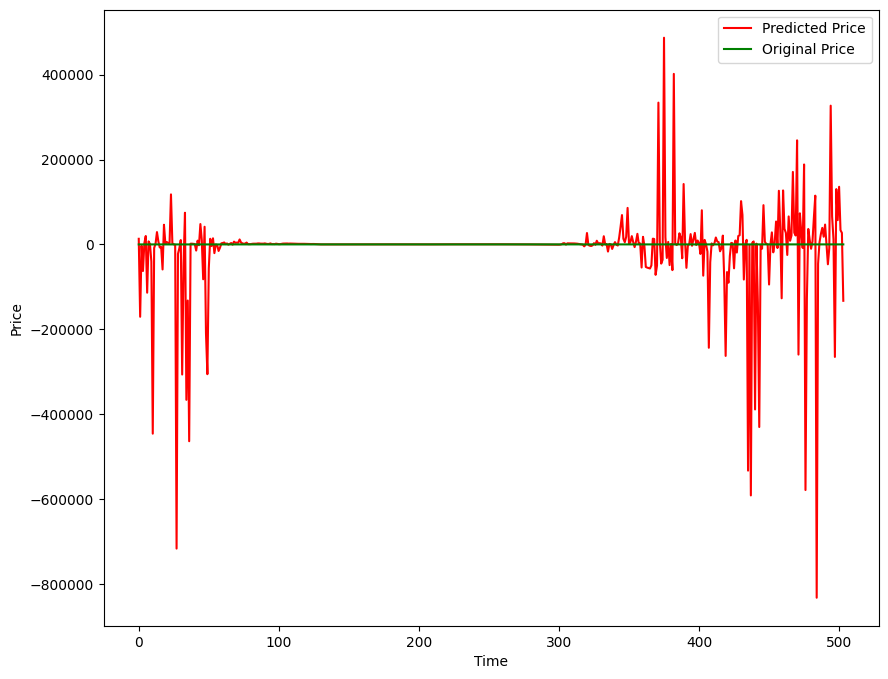

In [44]:
plt.figure(figsize=(10,8))
plt.plot(y_predict, 'r', label = 'Predicted Price')
plt.plot(y, 'g', label = 'Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [45]:
model_gru.save('Stock_Predictions_Model_gru.keras')